# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [50]:
%matplotlib inline
import pandas as pd 
import numpy as np

In [2]:
titles = [] # list of news titles
categories = [] # list of news categories
labels = [] # list of different categories (without repetitions)
nlabels = 4 # number of different categories
lnews = [] # list of dictionaries with two fields: one for the news and 
            # the other for its category

In [7]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip *.zip

--2019-01-07 10:50:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/zip]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M   396KB/s    in 2m 5s   

2019-01-07 10:52:59 (228 KB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [23]:
!cat readme.txt | grep -E "(FORMAT|FILENAME)"

FORMAT: Tab delimited CSV files. 
FILENAME #1: newsCorpora.csv (102.297.000 bytes)
FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
FILENAME #2: 2pageSessions.csv (3.049.986 bytes)
FORMAT: STORY \t HOSTNAME \t CATEGORY \t URL


In [55]:
def import_data():
    global titles, labels, categories
    # importing news aggregator data via Pandas (Python Data Analysis Library)
    colnames = ['Id', 'Title', 'Url', 'Publisher', 'Category', 'Story', 'Hostname', 'Timestamp']
    dtypes = [np.uint64, np.character, np.character, np.character, np.object, np.character, np.character, np.int64]
    col_dtypes = {col: t for col, t in zip(colnames, dtypes)}
    news = pd.read_table("./newsCorpora.csv", dtype=col_dtypes, names=colnames, header=None, sep='\t')
    # function 'head' shows the first 5 items in a column (or
    # the first 5 rows in the DataFrame)
    categories = news['Category']
    labels = sorted(list(set(categories)))
        
    return labels, news

In [60]:
categories, df = import_data()

In [65]:
from collections import Counter

def count_data(labels,categories):    
    c = Counter(categories)
    cont = dict(c)
    # total number of news
    tot = sum(list(cont.values()))     
    d = {
        "category" : labels,
        "news" : [cont[l] for l in labels],
        "percent" : [cont[l]/tot for l in labels]
    }
   
    print(pd.DataFrame(d))   
    print("total \t",tot) 
    
    return cont

cont = count_data(categories, df['Category'])

  category    news   percent
0        b  115967  0.274531
1        e  152469  0.360943
2        m   45639  0.108042
3        t  108344  0.256485
total 	 422419


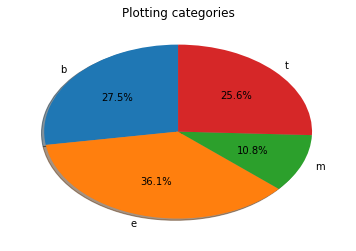

In [76]:
import pylab as pl # useful for drawing graphics

def categories_pie_plot(labels, cont, tit):
    sizes = [cont[l] for l in labels]
    pl.pie(sizes, explode=(0, 0, 0, 0), labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=90)
    pl.title(tit)
    pl.show()
    
categories_pie_plot(categories, cont,"Plotting categories")

In [72]:
from sklearn.utils import shuffle # Shuffle arrays in a consistent way

def split_data(titles, categories):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    N = len(titles)
    Ntrain = int(N * 0.7)    
    # Let's shuffle the data
    titles, categories = shuffle(titles, categories, random_state=0)
    X_train = titles[:Ntrain]
    y_train = categories[:Ntrain]
    X_test = titles[Ntrain:]
    y_test = categories[Ntrain:]
    
    return X_train, y_train, X_test, y_test

X_tr, y_tr, X_te, y_te = split_data(df['Title'], df['Category'])

In [74]:
cont2 = count_data(categories, y_tr)

  category    news   percent
0        b   81238  0.274738
1        e  106844  0.361334
2        m   31930  0.107984
3        t   75681  0.255945
total 	 295693


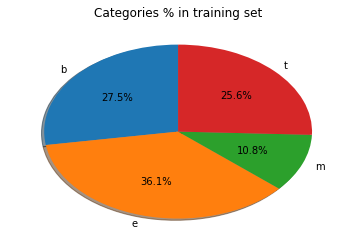

In [78]:
categories_pie_plot(categories, cont2,"Categories % in training set")

In [84]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline 
from sklearn import metrics 
import numpy as np
import pprint

def train_test(X_tr, y_tr, X_te, y_te, labels):
    # 1. Tokenize the titles
    # 2. Score each token by tf-idf frequency - which
    #    gives a weight to each token according to its
    #    frequency, scaled by the degree to which the term
    #    does not occur. 
    # 3. Estimate final weights using naive bayes 
    #    (opaque to me at the moment)
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB()),
                         ])
    
    # Fit the training set
    text_clf = text_clf.fit(X_tr, y_tr)
    
    # Predict using the test set
    predicted = text_clf.predict(X_te)
    
    return predicted

In [87]:
test_set_predictions = train_test(X_tr, y_tr, X_te, y_te, categories)

In [88]:
metrics.accuracy_score(y_te, test_set_predictions)

0.9238041128103152

In [92]:
print(metrics.classification_report(y_te, test_set_predictions, target_names=categories))

             precision    recall  f1-score   support

          b       0.90      0.91      0.90     34729
          e       0.95      0.97      0.96     45625
          m       0.97      0.85      0.90     13709
          t       0.90      0.90      0.90     32663

avg / total       0.92      0.92      0.92    126726



In [95]:
mat = metrics.confusion_matrix(y_te, test_set_predictions, labels=categories)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
cm

array([[0.91004636, 0.02361139, 0.00552852, 0.06081373],
       [0.01176986, 0.97192329, 0.00192877, 0.01437808],
       [0.06200306, 0.06193012, 0.84601357, 0.03005325],
       [0.06778312, 0.02510486, 0.00324526, 0.90386676]])

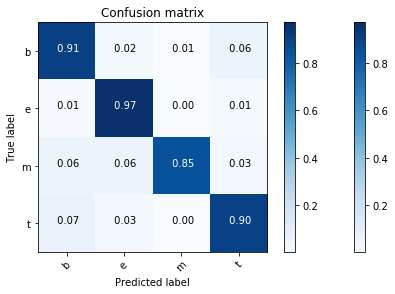

In [99]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:5.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()

plot_confusion_matrix(cm, categories, title='Confusion matrix')

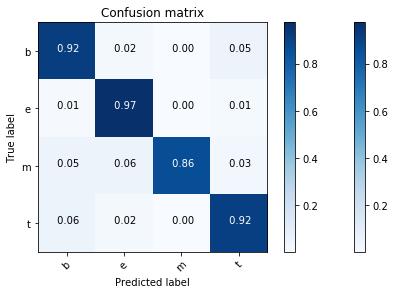

In [101]:
# Conversely we should expect near perfect predictions to the training
# set which gives us a sense of how well fit the model is

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
    
# Fit the training set
text_clf = pipeline.fit(X_tr, y_tr)

# Predict using the test set
predicted = text_clf.predict(X_tr)

mat = metrics.confusion_matrix(y_tr, predicted, labels=categories)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm, categories, title='Confusion matrix')

In [98]:
def resume_data(labels,y_train,f1s):
    c = Counter(y_train)
    cont = dict(c)
    tot = sum(list(cont.values()))
    nlabels = len(labels)
    d = {
        "category" : [labels[i] for i in range(nlabels)],
        "percent" : [cont[labels[i]]/tot for i in range(nlabels)],
        "f1-score" : [f1s[i] for i in range(nlabels)]
    }
   
    print(pd.DataFrame(d))   
    print("total \t",tot) 
    return cont

f1s = metrics.f1_score(y_te, test_set_predictions, labels=categories, average=None)
cont3 = resume_data(categories,y_tr,f1s)

  category   percent  f1-score
0        b  0.274738  0.903839
1        e  0.361334  0.959225
2        m  0.107984  0.902814
3        t  0.255945  0.903314
total 	 295693


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about